In [ ]:
# Load Libraries 
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
from keras.utils.vis_utils import plot_model
np.random.seed(20)   
tf.random.set_seed(20)

In [ ]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1] 
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()}) 
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(),'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','Time','V_filt','SS']]
df_SS = df[['freqQAmpI_filt','C_filt','SS']] 
df_V = df[['freqQAmpI_filt','C_filt','V_filt']] 
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
         freqQAmpI_filt       C_filt
0         31453.223522  5490.232850
1         31438.277060  5490.239343
2         31421.341616  5490.240838
3         31409.798761  5490.232728
4         31398.815589  5490.222463
...                ...          ...
132394    31055.686766  5457.051859
132395    31041.955345  5457.082380
132396    31035.059531  5457.111463
132397    31020.001291  5457.126443
132398    31012.016780  5457.151945

[132399 rows x 2 columns]
Target Data:
               SS    V_filt
0       5.656166  1.201004
1       5.657157  1.243144
2       5.658317  1.264215
3       5.659499  1.243144
4       5.660404  1.222074
...          ...       ...
132394  5.471059  1.285285
132395  5.474545  0.948161
132396  5.478286  1.158863
132397  5.481751  1.201004
132398  5.484813  0.526756

[132399 rows x 2 columns]


In [ ]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))

# Reshape 
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (132099, 300, 2)
Target shape (SS), Y =  (132099,)
Target shape (V), Y =  (132099,)
After reshaping, X =  (132099, 600)


In [ ]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Select Train
X_train = X_train[79259:92469] 
Y_train_SS = Y_train_SS[79259:92469]
Y_train_V = Y_train_V[79259:92469]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 13210
Validation samples: 13210
Testing samples: 26420


In [ ]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [ ]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

**Define Data-Driven Model**

In [ ]:
# Define DD
def MLP_Data():

  # Define inputs
  X_train = layers.Input(shape=(600),name='X_train')    

  # Prediction: Shear Stress + Slip Rate
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  v_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train],outputs=[ss_pred,v_pred])
  return model

In [ ]:
# Model Summary
model=MLP_Data()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          76928       ['X_train[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 32)           2080        ['dense_1[0][0]']                
                                                                                              

Train on 13210 samples, validate on 13210 samples
Epoch 1/100
13088/13210 [============================>.] - ETA: 0s - loss: 0.0638 - dense_5_loss: 0.0494 - dense_6_loss: 0.0144 - dense_5_mse: 0.0494 - dense_6_mse: 0.0144

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.04291, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


13210/13210 [==============================] - 4s 336us/sample - loss: 0.0635 - dense_5_loss: 0.0490 - dense_6_loss: 0.0144 - dense_5_mse: 0.0491 - dense_6_mse: 0.0144 - val_loss: 0.0429 - val_dense_5_loss: 0.0258 - val_dense_6_loss: 0.0171 - val_dense_5_mse: 0.0258 - val_dense_6_mse: 0.0171
Epoch 2/100
13056/13210 [============================>.] - ETA: 0s - loss: 0.0240 - dense_5_loss: 0.0095 - dense_6_loss: 0.0144 - dense_5_mse: 0.0095 - dense_6_mse: 0.0144
Epoch 2: val_loss improved from 0.04291 to 0.02571, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


13210/13210 [==============================] - 2s 170us/sample - loss: 0.0239 - dense_5_loss: 0.0095 - dense_6_loss: 0.0143 - dense_5_mse: 0.0095 - dense_6_mse: 0.0144 - val_loss: 0.0257 - val_dense_5_loss: 0.0086 - val_dense_6_loss: 0.0171 - val_dense_5_mse: 0.0086 - val_dense_6_mse: 0.0171
Epoch 3/100
12480/13210 [===========================>..] - ETA: 0s - loss: 0.0206 - dense_5_loss: 0.0060 - dense_6_loss: 0.0146 - dense_5_mse: 0.0060 - dense_6_mse: 0.0146
Epoch 3: val_loss did not improve from 0.02571
13210/13210 [==============================] - 1s 89us/sample - loss: 0.0202 - dense_5_loss: 0.0059 - dense_6_loss: 0.0143 - dense_5_mse: 0.0059 - dense_6_mse: 0.0143 - val_loss: 0.0302 - val_dense_5_loss: 0.0132 - val_dense_6_loss: 0.0170 - val_dense_5_mse: 0.0132 - val_dense_6_mse: 0.0170
Epoch 4/100
12512/13210 [===========================>..] - ETA: 0s - loss: 0.0193 - dense_5_loss: 0.0048 - dense_6_loss: 0.0145 - dense_5_mse: 0.0048 - dense_6_mse: 0.0145
Epoch 4: val_loss improv

13210/13210 [==============================] - 2s 167us/sample - loss: 0.0190 - dense_5_loss: 0.0047 - dense_6_loss: 0.0143 - dense_5_mse: 0.0047 - dense_6_mse: 0.0143 - val_loss: 0.0225 - val_dense_5_loss: 0.0055 - val_dense_6_loss: 0.0170 - val_dense_5_mse: 0.0055 - val_dense_6_mse: 0.0170
Epoch 5/100
12352/13210 [===========================>..] - ETA: 0s - loss: 0.0178 - dense_5_loss: 0.0037 - dense_6_loss: 0.0141 - dense_5_mse: 0.0037 - dense_6_mse: 0.0141
Epoch 5: val_loss improved from 0.02252 to 0.02167, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


13210/13210 [==============================] - 2s 170us/sample - loss: 0.0179 - dense_5_loss: 0.0037 - dense_6_loss: 0.0142 - dense_5_mse: 0.0037 - dense_6_mse: 0.0142 - val_loss: 0.0217 - val_dense_5_loss: 0.0049 - val_dense_6_loss: 0.0168 - val_dense_5_mse: 0.0049 - val_dense_6_mse: 0.0168
Epoch 6/100
13056/13210 [============================>.] - ETA: 0s - loss: 0.0170 - dense_5_loss: 0.0031 - dense_6_loss: 0.0139 - dense_5_mse: 0.0031 - dense_6_mse: 0.0139
Epoch 6: val_loss improved from 0.02167 to 0.01826, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


13210/13210 [==============================] - 2s 186us/sample - loss: 0.0169 - dense_5_loss: 0.0031 - dense_6_loss: 0.0138 - dense_5_mse: 0.0031 - dense_6_mse: 0.0138 - val_loss: 0.0183 - val_dense_5_loss: 0.0050 - val_dense_6_loss: 0.0133 - val_dense_5_mse: 0.0050 - val_dense_6_mse: 0.0133
Epoch 7/100
12736/13210 [===========================>..] - ETA: 0s - loss: 0.0146 - dense_5_loss: 0.0043 - dense_6_loss: 0.0102 - dense_5_mse: 0.0043 - dense_6_mse: 0.0102
Epoch 7: val_loss did not improve from 0.01826
13210/13210 [==============================] - 1s 84us/sample - loss: 0.0146 - dense_5_loss: 0.0043 - dense_6_loss: 0.0102 - dense_5_mse: 0.0043 - dense_6_mse: 0.0102 - val_loss: 0.0216 - val_dense_5_loss: 0.0126 - val_dense_6_loss: 0.0089 - val_dense_5_mse: 0.0126 - val_dense_6_mse: 0.0089
Epoch 8/100
12928/13210 [============================>.] - ETA: 0s - loss: 0.0120 - dense_5_loss: 0.0038 - dense_6_loss: 0.0082 - dense_5_mse: 0.0038 - dense_6_mse: 0.0082
Epoch 8: val_loss improv

13210/13210 [==============================] - 2s 174us/sample - loss: 0.0119 - dense_5_loss: 0.0038 - dense_6_loss: 0.0081 - dense_5_mse: 0.0038 - dense_6_mse: 0.0081 - val_loss: 0.0104 - val_dense_5_loss: 0.0035 - val_dense_6_loss: 0.0069 - val_dense_5_mse: 0.0035 - val_dense_6_mse: 0.0069
Epoch 9/100
12320/13210 [==========================>...] - ETA: 0s - loss: 0.0143 - dense_5_loss: 0.0035 - dense_6_loss: 0.0108 - dense_5_mse: 0.0035 - dense_6_mse: 0.0108
Epoch 9: val_loss did not improve from 0.01040
13210/13210 [==============================] - 1s 81us/sample - loss: 0.0138 - dense_5_loss: 0.0034 - dense_6_loss: 0.0104 - dense_5_mse: 0.0034 - dense_6_mse: 0.0104 - val_loss: 0.0150 - val_dense_5_loss: 0.0063 - val_dense_6_loss: 0.0087 - val_dense_5_mse: 0.0063 - val_dense_6_mse: 0.0087
Epoch 10/100
12544/13210 [===========================>..] - ETA: 0s - loss: 0.0086 - dense_5_loss: 0.0033 - dense_6_loss: 0.0053 - dense_5_mse: 0.0033 - dense_6_mse: 0.0053
Epoch 10: val_loss impr

13210/13210 [==============================] - 2s 174us/sample - loss: 0.0085 - dense_5_loss: 0.0033 - dense_6_loss: 0.0052 - dense_5_mse: 0.0033 - dense_6_mse: 0.0052 - val_loss: 0.0066 - val_dense_5_loss: 0.0026 - val_dense_6_loss: 0.0040 - val_dense_5_mse: 0.0026 - val_dense_6_mse: 0.0040
Epoch 11/100
13152/13210 [============================>.] - ETA: 0s - loss: 0.0056 - dense_5_loss: 0.0023 - dense_6_loss: 0.0033 - dense_5_mse: 0.0023 - dense_6_mse: 0.0033
Epoch 11: val_loss did not improve from 0.00660
13210/13210 [==============================] - 1s 88us/sample - loss: 0.0056 - dense_5_loss: 0.0023 - dense_6_loss: 0.0033 - dense_5_mse: 0.0023 - dense_6_mse: 0.0033 - val_loss: 0.0112 - val_dense_5_loss: 0.0068 - val_dense_6_loss: 0.0045 - val_dense_5_mse: 0.0068 - val_dense_6_mse: 0.0045
Epoch 12/100
12448/13210 [===========================>..] - ETA: 0s - loss: 0.0061 - dense_5_loss: 0.0023 - dense_6_loss: 0.0038 - dense_5_mse: 0.0023 - dense_6_mse: 0.0038
Epoch 12: val_loss di

13210/13210 [==============================] - 2s 168us/sample - loss: 0.0045 - dense_5_loss: 0.0019 - dense_6_loss: 0.0026 - dense_5_mse: 0.0019 - dense_6_mse: 0.0026 - val_loss: 0.0044 - val_dense_5_loss: 0.0021 - val_dense_6_loss: 0.0023 - val_dense_5_mse: 0.0021 - val_dense_6_mse: 0.0023
Epoch 15/100
13088/13210 [============================>.] - ETA: 0s - loss: 0.0037 - dense_5_loss: 0.0017 - dense_6_loss: 0.0020 - dense_5_mse: 0.0017 - dense_6_mse: 0.0020
Epoch 15: val_loss did not improve from 0.00439
13210/13210 [==============================] - 1s 78us/sample - loss: 0.0037 - dense_5_loss: 0.0017 - dense_6_loss: 0.0021 - dense_5_mse: 0.0017 - dense_6_mse: 0.0020 - val_loss: 0.0068 - val_dense_5_loss: 0.0022 - val_dense_6_loss: 0.0046 - val_dense_5_mse: 0.0022 - val_dense_6_mse: 0.0046
Epoch 16/100
12448/13210 [===========================>..] - ETA: 0s - loss: 0.0044 - dense_5_loss: 0.0018 - dense_6_loss: 0.0026 - dense_5_mse: 0.0018 - dense_6_mse: 0.0026
Epoch 16: val_loss di

13210/13210 [==============================] - 2s 168us/sample - loss: 0.0031 - dense_5_loss: 0.0014 - dense_6_loss: 0.0017 - dense_5_mse: 0.0014 - dense_6_mse: 0.0017 - val_loss: 0.0041 - val_dense_5_loss: 0.0023 - val_dense_6_loss: 0.0018 - val_dense_5_mse: 0.0023 - val_dense_6_mse: 0.0018
Epoch 18/100
12416/13210 [===========================>..] - ETA: 0s - loss: 0.0037 - dense_5_loss: 0.0018 - dense_6_loss: 0.0019 - dense_5_mse: 0.0018 - dense_6_mse: 0.0019
Epoch 18: val_loss did not improve from 0.00408
13210/13210 [==============================] - 1s 83us/sample - loss: 0.0036 - dense_5_loss: 0.0017 - dense_6_loss: 0.0019 - dense_5_mse: 0.0017 - dense_6_mse: 0.0019 - val_loss: 0.0070 - val_dense_5_loss: 0.0021 - val_dense_6_loss: 0.0049 - val_dense_5_mse: 0.0021 - val_dense_6_mse: 0.0049
Epoch 19/100
12800/13210 [============================>.] - ETA: 0s - loss: 0.0029 - dense_5_loss: 0.0014 - dense_6_loss: 0.0015 - dense_5_mse: 0.0014 - dense_6_mse: 0.0015
Epoch 19: val_loss di

13210/13210 [==============================] - 3s 234us/sample - loss: 0.0032 - dense_5_loss: 0.0016 - dense_6_loss: 0.0017 - dense_5_mse: 0.0016 - dense_6_mse: 0.0017 - val_loss: 0.0041 - val_dense_5_loss: 0.0021 - val_dense_6_loss: 0.0020 - val_dense_5_mse: 0.0021 - val_dense_6_mse: 0.0020
Epoch 21/100
12576/13210 [===========================>..] - ETA: 0s - loss: 0.0032 - dense_5_loss: 0.0015 - dense_6_loss: 0.0016 - dense_5_mse: 0.0015 - dense_6_mse: 0.0016
Epoch 21: val_loss improved from 0.00405 to 0.00374, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


13210/13210 [==============================] - 2s 165us/sample - loss: 0.0031 - dense_5_loss: 0.0015 - dense_6_loss: 0.0016 - dense_5_mse: 0.0015 - dense_6_mse: 0.0016 - val_loss: 0.0037 - val_dense_5_loss: 0.0021 - val_dense_6_loss: 0.0017 - val_dense_5_mse: 0.0021 - val_dense_6_mse: 0.0017
Epoch 22/100
12736/13210 [===========================>..] - ETA: 0s - loss: 0.0034 - dense_5_loss: 0.0016 - dense_6_loss: 0.0018 - dense_5_mse: 0.0016 - dense_6_mse: 0.0018
Epoch 22: val_loss improved from 0.00374 to 0.00373, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


13210/13210 [==============================] - 2s 165us/sample - loss: 0.0034 - dense_5_loss: 0.0016 - dense_6_loss: 0.0018 - dense_5_mse: 0.0016 - dense_6_mse: 0.0018 - val_loss: 0.0037 - val_dense_5_loss: 0.0015 - val_dense_6_loss: 0.0023 - val_dense_5_mse: 0.0015 - val_dense_6_mse: 0.0023
Epoch 23/100
12512/13210 [===========================>..] - ETA: 0s - loss: 0.0032 - dense_5_loss: 0.0016 - dense_6_loss: 0.0016 - dense_5_mse: 0.0016 - dense_6_mse: 0.0016
Epoch 23: val_loss did not improve from 0.00373
13210/13210 [==============================] - 1s 78us/sample - loss: 0.0031 - dense_5_loss: 0.0016 - dense_6_loss: 0.0015 - dense_5_mse: 0.0016 - dense_6_mse: 0.0015 - val_loss: 0.0049 - val_dense_5_loss: 0.0030 - val_dense_6_loss: 0.0020 - val_dense_5_mse: 0.0030 - val_dense_6_mse: 0.0020
Epoch 24/100
12640/13210 [===========================>..] - ETA: 0s - loss: 0.0036 - dense_5_loss: 0.0015 - dense_6_loss: 0.0021 - dense_5_mse: 0.0015 - dense_6_mse: 0.0021
Epoch 24: val_loss im

13210/13210 [==============================] - 2s 164us/sample - loss: 0.0036 - dense_5_loss: 0.0015 - dense_6_loss: 0.0020 - dense_5_mse: 0.0015 - dense_6_mse: 0.0020 - val_loss: 0.0035 - val_dense_5_loss: 0.0018 - val_dense_6_loss: 0.0017 - val_dense_5_mse: 0.0018 - val_dense_6_mse: 0.0017
Epoch 25/100
13120/13210 [============================>.] - ETA: 0s - loss: 0.0031 - dense_5_loss: 0.0015 - dense_6_loss: 0.0016 - dense_5_mse: 0.0015 - dense_6_mse: 0.0016
Epoch 25: val_loss did not improve from 0.00345
13210/13210 [==============================] - 1s 83us/sample - loss: 0.0031 - dense_5_loss: 0.0015 - dense_6_loss: 0.0016 - dense_5_mse: 0.0015 - dense_6_mse: 0.0016 - val_loss: 0.0059 - val_dense_5_loss: 0.0025 - val_dense_6_loss: 0.0034 - val_dense_5_mse: 0.0025 - val_dense_6_mse: 0.0034
Epoch 26/100
13120/13210 [============================>.] - ETA: 0s - loss: 0.0032 - dense_5_loss: 0.0015 - dense_6_loss: 0.0017 - dense_5_mse: 0.0015 - dense_6_mse: 0.0017
Epoch 26: val_loss di

13210/13210 [==============================] - 2s 166us/sample - loss: 0.0022 - dense_5_loss: 0.0011 - dense_6_loss: 0.0011 - dense_5_mse: 0.0011 - dense_6_mse: 0.0011 - val_loss: 0.0034 - val_dense_5_loss: 0.0019 - val_dense_6_loss: 0.0015 - val_dense_5_mse: 0.0019 - val_dense_6_mse: 0.0015
Epoch 40/100
12608/13210 [===========================>..] - ETA: 0s - loss: 0.0030 - dense_5_loss: 0.0013 - dense_6_loss: 0.0017 - dense_5_mse: 0.0013 - dense_6_mse: 0.0017
Epoch 40: val_loss did not improve from 0.00339
13210/13210 [==============================] - 1s 82us/sample - loss: 0.0030 - dense_5_loss: 0.0013 - dense_6_loss: 0.0016 - dense_5_mse: 0.0013 - dense_6_mse: 0.0016 - val_loss: 0.0043 - val_dense_5_loss: 0.0017 - val_dense_6_loss: 0.0026 - val_dense_5_mse: 0.0017 - val_dense_6_mse: 0.0026
Epoch 41/100
13184/13210 [============================>.] - ETA: 0s - loss: 0.0021 - dense_5_loss: 9.8276e-04 - dense_6_loss: 0.0011 - dense_5_mse: 9.8276e-04 - dense_6_mse: 0.0011
Epoch 41: val

13210/13210 [==============================] - 2s 181us/sample - loss: 0.0021 - dense_5_loss: 9.8180e-04 - dense_6_loss: 0.0011 - dense_5_mse: 9.8198e-04 - dense_6_mse: 0.0011 - val_loss: 0.0027 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0016 - val_dense_5_mse: 0.0012 - val_dense_6_mse: 0.0016
Epoch 42/100
12704/13210 [===========================>..] - ETA: 0s - loss: 0.0018 - dense_5_loss: 8.4662e-04 - dense_6_loss: 9.5618e-04 - dense_5_mse: 8.4662e-04 - dense_6_mse: 9.5618e-04
Epoch 42: val_loss did not improve from 0.00274
13210/13210 [==============================] - 1s 84us/sample - loss: 0.0018 - dense_5_loss: 8.4483e-04 - dense_6_loss: 9.6869e-04 - dense_5_mse: 8.4466e-04 - dense_6_mse: 9.6794e-04 - val_loss: 0.0048 - val_dense_5_loss: 0.0025 - val_dense_6_loss: 0.0023 - val_dense_5_mse: 0.0025 - val_dense_6_mse: 0.0023
Epoch 43/100
12256/13210 [==========================>...] - ETA: 0s - loss: 0.0027 - dense_5_loss: 0.0013 - dense_6_loss: 0.0014 - dense_5_mse: 0.0013 - d

13210/13210 [==============================] - 2s 172us/sample - loss: 0.0020 - dense_5_loss: 8.5956e-04 - dense_6_loss: 0.0011 - dense_5_mse: 8.5984e-04 - dense_6_mse: 0.0011 - val_loss: 0.0025 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0013 - val_dense_5_mse: 0.0012 - val_dense_6_mse: 0.0013
Epoch 57/100
13210/13210 [==============================] - ETA: 0s - loss: 0.0019 - dense_5_loss: 7.7609e-04 - dense_6_loss: 0.0011 - dense_5_mse: 7.7570e-04 - dense_6_mse: 0.0011
Epoch 57: val_loss did not improve from 0.00249
13210/13210 [==============================] - 1s 86us/sample - loss: 0.0019 - dense_5_loss: 7.7609e-04 - dense_6_loss: 0.0011 - dense_5_mse: 7.7570e-04 - dense_6_mse: 0.0011 - val_loss: 0.0038 - val_dense_5_loss: 0.0023 - val_dense_6_loss: 0.0015 - val_dense_5_mse: 0.0023 - val_dense_6_mse: 0.0015
Epoch 58/100
13024/13210 [============================>.] - ETA: 0s - loss: 0.0018 - dense_5_loss: 7.9263e-04 - dense_6_loss: 0.0010 - dense_5_mse: 7.9263e-04 - dense_6_m

13210/13210 [==============================] - 2s 164us/sample - loss: 0.0016 - dense_5_loss: 7.2041e-04 - dense_6_loss: 9.2809e-04 - dense_5_mse: 7.2027e-04 - dense_6_mse: 9.2482e-04 - val_loss: 0.0025 - val_dense_5_loss: 0.0014 - val_dense_6_loss: 0.0011 - val_dense_5_mse: 0.0014 - val_dense_6_mse: 0.0011
Epoch 64/100
12736/13210 [===========================>..] - ETA: 0s - loss: 0.0015 - dense_5_loss: 6.0268e-04 - dense_6_loss: 9.0521e-04 - dense_5_mse: 6.0268e-04 - dense_6_mse: 9.0521e-04
Epoch 64: val_loss did not improve from 0.00247
13210/13210 [==============================] - 1s 84us/sample - loss: 0.0015 - dense_5_loss: 6.0389e-04 - dense_6_loss: 9.1161e-04 - dense_5_mse: 6.0396e-04 - dense_6_mse: 9.1044e-04 - val_loss: 0.0040 - val_dense_5_loss: 0.0015 - val_dense_6_loss: 0.0025 - val_dense_5_mse: 0.0015 - val_dense_6_mse: 0.0025
Epoch 65/100
12768/13210 [===========================>..] - ETA: 0s - loss: 0.0025 - dense_5_loss: 0.0010 - dense_6_loss: 0.0015 - dense_5_mse: 0.

13210/13210 [==============================] - 2s 170us/sample - loss: 0.0016 - dense_5_loss: 6.5725e-04 - dense_6_loss: 9.6296e-04 - dense_5_mse: 6.5717e-04 - dense_6_mse: 9.6330e-04 - val_loss: 0.0023 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0011 - val_dense_5_mse: 0.0012 - val_dense_6_mse: 0.0011
Epoch 79/100
12864/13210 [============================>.] - ETA: 0s - loss: 0.0019 - dense_5_loss: 7.8695e-04 - dense_6_loss: 0.0011 - dense_5_mse: 7.8695e-04 - dense_6_mse: 0.0011
Epoch 79: val_loss did not improve from 0.00231
13210/13210 [==============================] - 1s 87us/sample - loss: 0.0019 - dense_5_loss: 7.8535e-04 - dense_6_loss: 0.0011 - dense_5_mse: 7.8529e-04 - dense_6_mse: 0.0011 - val_loss: 0.0041 - val_dense_5_loss: 0.0020 - val_dense_6_loss: 0.0021 - val_dense_5_mse: 0.0020 - val_dense_6_mse: 0.0021
Epoch 80/100
12864/13210 [============================>.] - ETA: 0s - loss: 0.0016 - dense_5_loss: 6.2796e-04 - dense_6_loss: 9.8007e-04 - dense_5_mse: 6.2796e-04

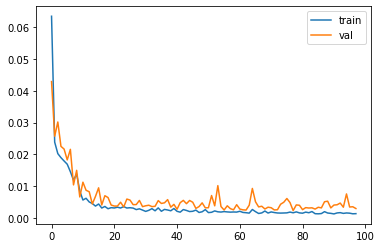

---Training time: 135.24222708 seconds ---


In [ ]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto')  
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS,Y_train_V], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_V]), verbose=1)
end_time = time.time()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [ ]:
# # Save the model
# print(model.summary())
# plot_model(model, show_shapes=True)
# model.save('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/Reference_p5270/Reference/DD_Transfer_model_70_10_20.h5')

In [ ]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,] 
y_predtrain_V =np.array(y_predtrain)[1,] 

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS) 
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS)) 

train_r2_V = r2_score(Y_train_V,y_predtrain_V ) 
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V )) 

# Model Performance: Validation 
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,] 
y_predval_V = np.array(y_predval)[1,] 

val_r2_SS = r2_score(Y_val_SS, y_predval_SS) 
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS)) 

val_r2_V = r2_score(Y_val_V, y_predval_V) 
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V)) 

# Model Performance: Testing 
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,] 
y_predtest_V = np.array(y_predtest)[1,] 

test_r2_SS = r2_score(y_test_SS,y_predtest_SS) 
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS)) 

test_r2_V = r2_score(y_test_V,y_predtest_V) 
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V)) 

# Print R2 Results 
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.99124, Train (V) - 0.96901
R2 scores: Validation (SS) - 0.97017, Validation (V) - 0.91131
R2 scores: Testing (SS) - 0.87325, Testing (V) - 0.69157
RMSE scores: Train (SS) - 0.01972, Train (V) - 0.02102
RMSE scores: Validation (SS) - 0.03846, Validation (V) - 0.03879
RMSE scores: Testing (SS) - 0.07768, Testing (V) - 0.07028


In [ ]:
# Inverse scaling: SS 
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [ ]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

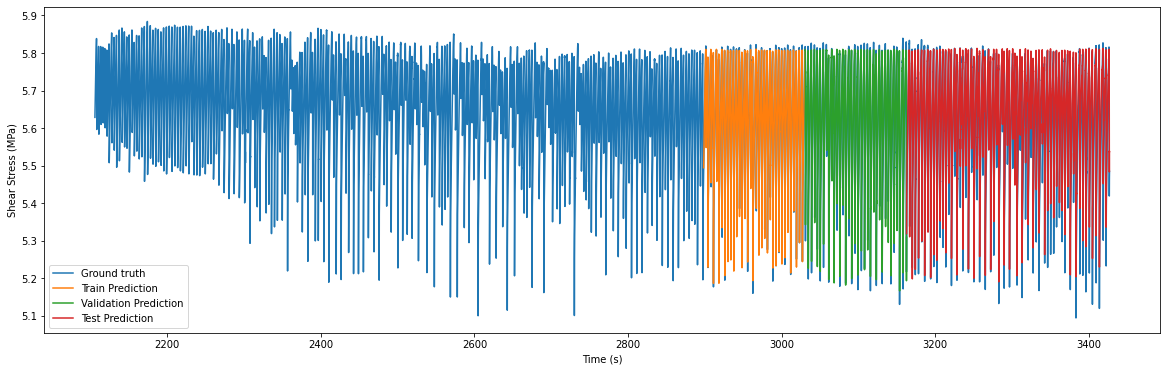

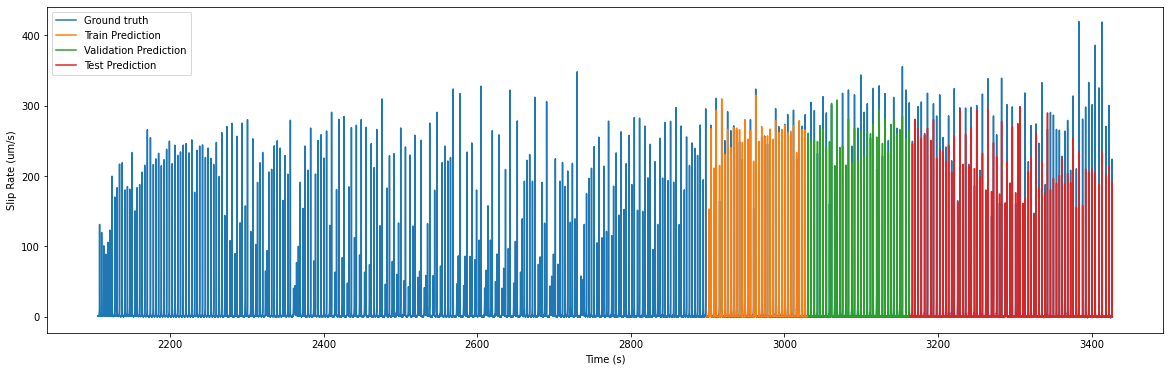

In [ ]:
# Overall plot: SS & V 
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[79259:92469] 

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

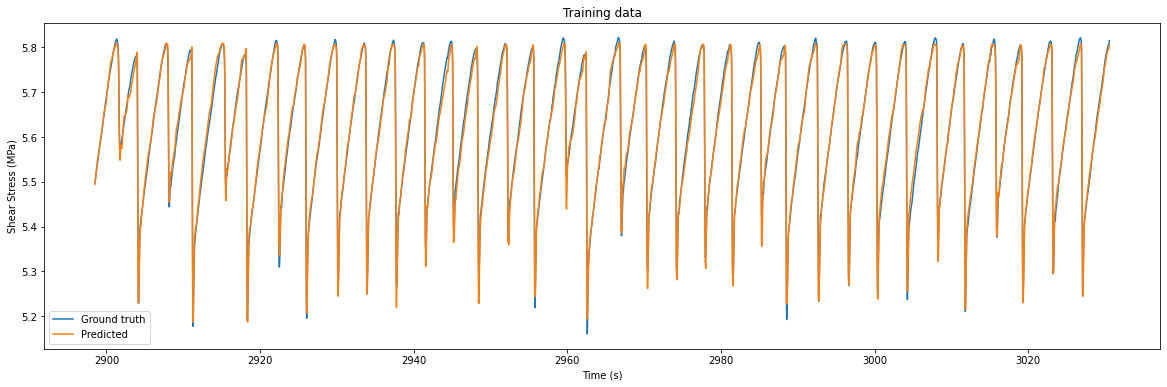

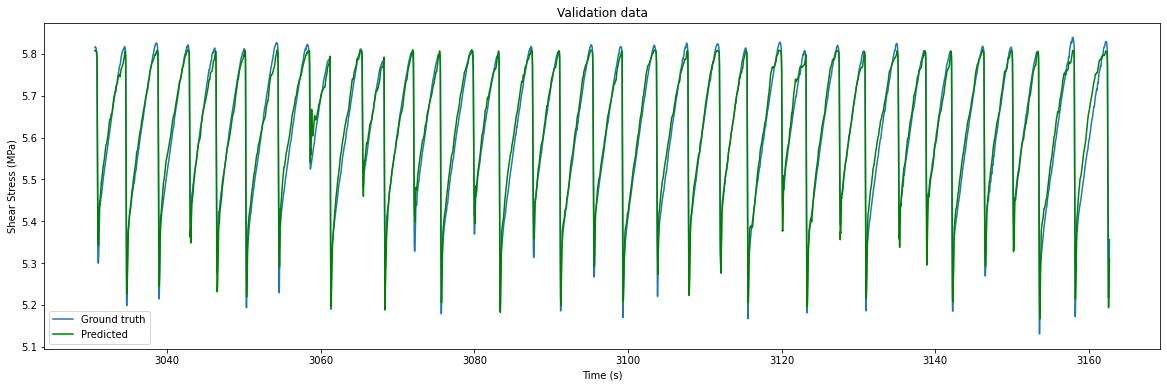

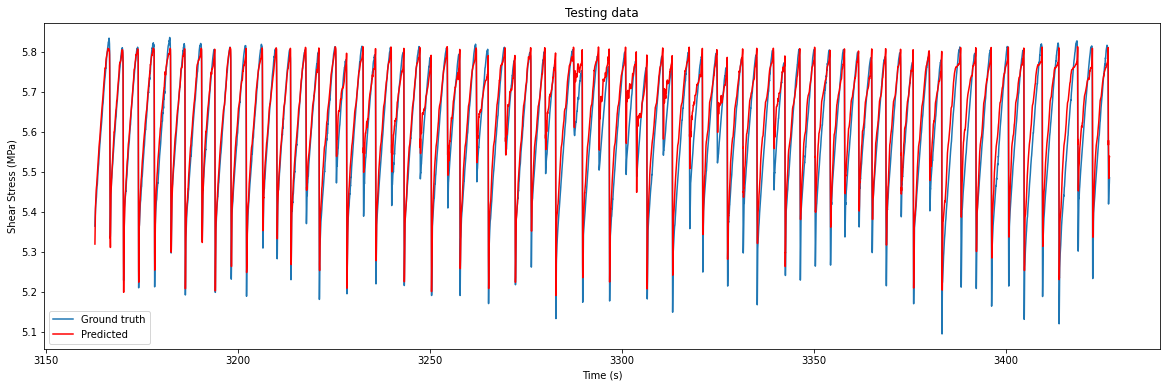

In [ ]:
# Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

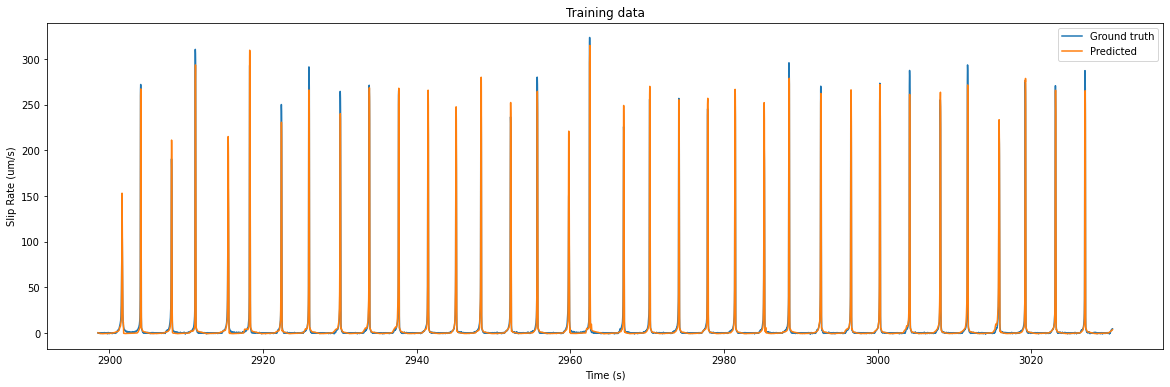

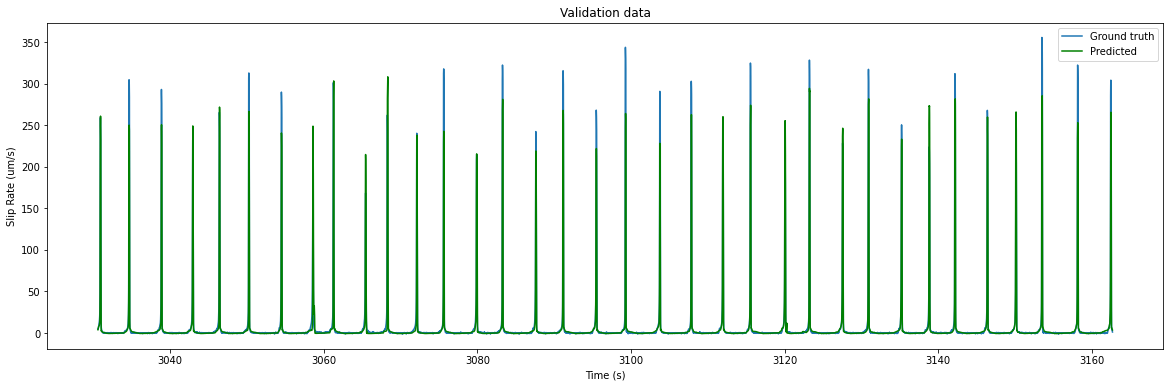

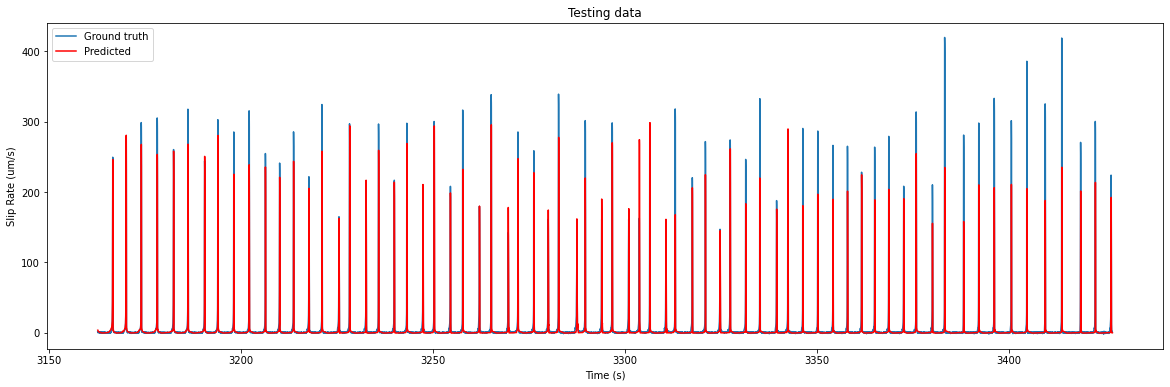

In [ ]:
# Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')

In [ ]:
# # Extract Data

# # Time 
# savetxt('Whole_time.csv', ttime, delimiter=',')
# savetxt('traintime.csv', traintime, delimiter=',')
# savetxt('valtime.csv', valtime, delimiter=',')
# savetxt('testtime.csv', testtime, delimiter=',')

# # SS
# savetxt('Y_train_SS.csv', Y_train_SS, delimiter=',')
# savetxt('Y_val_SS.csv', Y_val_SS, delimiter=',')
# savetxt('y_test_SS.csv', y_test_SS, delimiter=',')
# savetxt('y_predtrain_SS.csv', y_predtrain_SS, delimiter=',')
# savetxt('y_predval_SS.csv', y_predval_SS, delimiter=',')
# savetxt('y_predtest_SS.csv', y_predtest_SS, delimiter=',')

# # V
# savetxt('Y_train_V.csv', Y_train_V, delimiter=',')
# savetxt('Y_val_V.csv', Y_val_V, delimiter=',')
# savetxt('y_test_V.csv', y_test_V, delimiter=',')
# savetxt('y_predtrain_V.csv', y_predtrain_V, delimiter=',')
# savetxt('y_predval_V.csv', y_predval_V, delimiter=',')
# savetxt('y_predtest_V.csv', y_predtest_V, delimiter=',')

# # Download
# files.download('Whole_time.csv')
# files.download('traintime.csv')
# files.download('valtime.csv')
# files.download('testtime.csv')

# files.download('Y_train_SS.csv')
# files.download('Y_val_SS.csv')
# files.download('y_test_SS.csv')
# files.download('y_predtrain_SS.csv')
# files.download('y_predval_SS.csv')
# files.download('y_predtest_SS.csv')

# files.download('Y_train_V.csv')
# files.download('Y_val_V.csv')
# files.download('y_test_V.csv')
# files.download('y_predtrain_V.csv')
# files.download('y_predval_V.csv')
# files.download('y_predtest_V.csv')